The purpose of this notebook is to model the decoherence of a qubit. We use a rotationally invariant linear product of spins in the Pauli matrix representation as the interaction Hamiltonian. The expectation is that time evolution under such a Hamiltonian will result in entanglement between the qubit and its environment, yielding a reduced mixed-state density matrix recognized by non-zero eigenvalues.

N > 1: The qubit is entangled with a multi-qubit environment. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import itertools

In [2]:
# helper functions
def create_env_basis_list(N):
    """
    Create 2^N different basis states from 0, 1

    Arguments:
    - N: The number of elements in the string to create.

    Returns:
    - perms: List of 2^N strings '0100...'
    """

    perms = list(itertools.product('01', repeat=N))
    
    return perms

def create_ham_order_list(N):
    """
    Create different permutations from 0, 1 for Hamiltonian

    Arguments:
    - N: The number of elements in the string to create.

    Returns:
    - perms: List of strings '0100...'
    """

    perms = list(itertools.permutations('0'*(N-1)+'1'))
    
    return perms

In [3]:
# define the qubit (our system)
up = np.array([1,0]).reshape(2,1)
down = np.array([0,1]).reshape(2,1)
    
c1 = np.sqrt(.999)
c2 = np.sqrt(.001)
qubit = np.array([c1, c2]) # c1|0> + c2|1>
qubit = qubit.reshape(2,1) # reshape as a 2x1 column vector

In [4]:
# define the environment (let's try N>1 now)
N = 2 # number of environmental qubits

q_env = down # get the ball rolling 
for n in range(N-1):
    #if np.round(np.random.rand()) == 0:
    q_env = np.kron(down, q_env)
    #else:
    #    q_env = np.kron(up, q_env)

In [5]:
# define the interaction Hamiltonian between qubit and evironment (linear product of spins)
# pauli matrices
i = complex(0,1)
id_mat = np.array([[1,0],[0,1]])
sigma_x = np.array([[0, 1], [1,0]])
sigma_y = np.array([[0, -i], [i,0]])
sigma_z = np.array([[1, 0], [0,-1]])

ham = 0
coupling = 10 # coupling strength between environment and qubit
'''
list_of_ham_orders = create_ham_order_list(N)
for perm in list_of_ham_orders:
    ham_x = sigma_x
    ham_y = sigma_y
    ham_z = sigma_z
    for j in perm: # note that order of elements in kronecker product will be reverse of perm, but will not matter in sum
        if j == '1':
            ham_x = np.kron(sigma_x, ham_x)
            ham_y = np.kron(sigma_y, ham_y)
            ham_z = np.kron(sigma_z, ham_z)
        elif j == '0':
            ham_x = np.kron(id_mat, ham_x)
            ham_y = np.kron(id_mat, ham_y)
            ham_z = np.kron(id_mat, ham_z)
    ham = ham + coupling*(ham_x + ham_y + ham_z)
'''

"\nlist_of_ham_orders = create_ham_order_list(N)\nfor perm in list_of_ham_orders:\n    ham_x = sigma_x\n    ham_y = sigma_y\n    ham_z = sigma_z\n    for j in perm: # note that order of elements in kronecker product will be reverse of perm, but will not matter in sum\n        if j == '1':\n            ham_x = np.kron(sigma_x, ham_x)\n            ham_y = np.kron(sigma_y, ham_y)\n            ham_z = np.kron(sigma_z, ham_z)\n        elif j == '0':\n            ham_x = np.kron(id_mat, ham_x)\n            ham_y = np.kron(id_mat, ham_y)\n            ham_z = np.kron(id_mat, ham_z)\n    ham = ham + coupling*(ham_x + ham_y + ham_z)\n"

In [6]:
# trying arbitrary hermitian matrices as the hamiltonian
ham = np.random.rand(2**(N+1), 2**(N+1)) + i*(np.random.rand(2**(N+1), 2**(N+1)))
ham = (ham + ham.conj().T)/2
#ham[0,-1]=i
#ham[-1,0]=-i

In [7]:
# define the global combined state of qubit and environment
q_global = np.kron(q_env, qubit)

In [8]:
# time evolve the global state d|psi> = -i*H|psi>dt
dt = .1
num_steps = 50000

# record the eigenvalues of the reduced density matrix
eigs_list = []
eigvects_list = []
rho_red_od_ll = []
rho_red_od_ur = []

for step in range(num_steps):
    #q_update = np.zeros(np.shape(q_global), dtype=complex)
    # trying a stochastic time-dependent Hamiltonian
    ham = np.random.rand(2**(N+1), 2**(N+1)) + i*(np.random.rand(2**(N+1), 2**(N+1)))
    ham = (ham + ham.conj().T)/2
    #ham[0,-1]=np.random.rand()*2*np.pi
    #ham[0,-2]=np.random.rand()*2*np.pi
    #ham[-1,0]=np.conj(ham[0,-1])
    #ham[-2,0]=np.conj(ham[0,-2])
    
    #for n in range(q_global.shape[0]):
    #    q_update[n] = -i*dt*np.dot(ham[n], q_global[n])
    #ham = ham*[np.cos(-2*np.pi*step*dt/(10*dt))+np.cos(-4*np.pi*step*dt/(10*dt))] # trying a time-dependent coupling to instigate decoherence
    q_update = -i*dt*np.dot(ham, q_global)
    heun_term = np.linalg.inv(np.identity(ham.shape[0]) + .5*i*dt*ham) # trying 2nd order solver
    q_global = np.matmul(heun_term, (q_global + q_update*.5))
    q_global_norm = np.sqrt(np.dot(q_global.conj().T, q_global))
    #if step%1000 == 0:
    #    print(q_global_norm)
    q_global = q_global/(q_global_norm) # need to explicitly normalize since linearization is non-unitary at 2nd order
    
    # form the density matrix of the time-evolved global state
    rho_global = np.outer(q_global, q_global.conj().T)
    
    # trace out the environmental state
    # environmental basis states in global hilbert space
    list_of_env_basis_states = create_env_basis_list(N)
    rho_red = 0
    for perm in list_of_env_basis_states:
        env_basis_state = id_mat
        for j in perm: # note that order of elements in kronecker product will be reverse of perm, but will not matter in trace
            if j == '1':
                env_basis_state = np.kron(up, env_basis_state)
            elif j == '0':
                env_basis_state = np.kron(down, env_basis_state)
        rho_red = np.matmul(env_basis_state.conj().T, np.matmul(rho_global, env_basis_state)) + rho_red
    
    # calculate the eigenvalues of the reduced density matrix
    eigs = np.linalg.eigvals(rho_red)
    eigs_list.append(eigs)
    
    # calculate the eigenvectors of the reduced density matrix
    w, eigvects = np.linalg.eig(rho_red)
    eigvects_list.append(eigvects)
    
    # store the off-diagonal terms of the reduced density matrix
    rho_red_od_ll.append(np.linalg.norm(rho_red[1,0]))
    rho_red_od_ur.append(np.linalg.norm(rho_red[0,1]))

In [9]:
# prep arrays for plotting
eigs_arr = np.array(eigs_list)
eig1 = np.real(np.min(eigs_arr, 1))
eig2 = np.real(np.max(eigs_arr, 1))
t_arr = np.arange(0,dt*num_steps,dt)

smooth_window = 1000 # units of dt
eig1_smooth = pd.Series(eig1).rolling(smooth_window).mean()
eig2_smooth = pd.Series(eig2).rolling(smooth_window).mean()
rho_red_od_ll_smooth = pd.Series(rho_red_od_ll).rolling(smooth_window).mean()
rho_red_od_ur_smooth = pd.Series(rho_red_od_ur).rolling(smooth_window).mean()

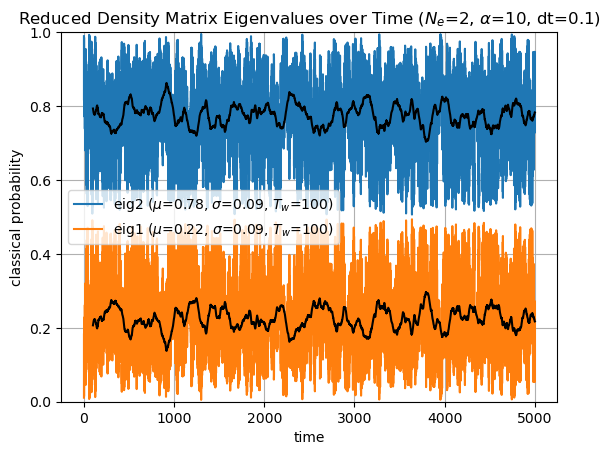

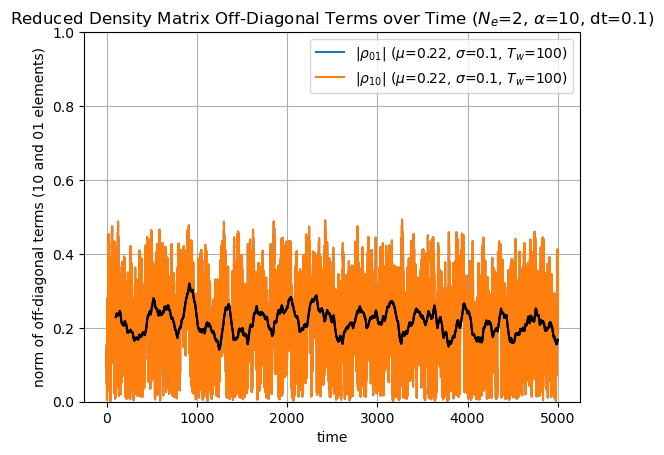

In [10]:
# plot the eigenvalues as a function of time
plt.figure()
plt.subplot()
plt.plot(t_arr, eig2,  label='eig2 ($\mu$='+str(np.round(np.mean(eig2),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(eig2),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, eig1, label='eig1 ($\mu$='+str(np.round(np.mean(eig1),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(eig1),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, eig1_smooth, color='black')
plt.plot(t_arr, eig2_smooth, color='black')
plt.grid()
plt.xlabel('time')
plt.ylabel('classical probability')
plt.title('Reduced Density Matrix Eigenvalues over Time ($N_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.ylim([0,1])
plt.legend()

plt.figure()
plt.subplot()
plt.plot(t_arr, rho_red_od_ur, label=r'$|\rho_{01}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_ll),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_ll),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_ll, label=r'$|\rho_{10}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_ll),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_ll),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_ll_smooth, color='black')
plt.plot(t_arr, rho_red_od_ur_smooth, color='black')
plt.grid()
plt.xlabel('time')
plt.ylabel('norm of off-diagonal terms (10 and 01 elements)')
plt.title('Reduced Density Matrix Off-Diagonal Terms over Time ($N_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.ylim([0,1])
plt.legend()

# Scratch Work

In [11]:
eigvects

array([[ 0.74669091+0.j       , -0.20432388-0.6330122j],
       [ 0.20432388-0.6330122j,  0.74669091+0.j       ]])

In [12]:
rho_red

array([[0.53747536+0.j        , 0.09935295+0.30780363j],
       [0.09935295-0.30780363j, 0.46252464+0.j        ]])

In [13]:
eigs_arr

array([[0.98905397+5.65967101e-19j, 0.01094603-5.65967101e-19j],
       [0.97139019-2.06588698e-18j, 0.02860981+2.06588698e-18j],
       [0.93864334+3.18285658e-18j, 0.06135666-3.18285658e-18j],
       ...,
       [0.82965656+1.74254036e-17j, 0.17034344-1.74254036e-17j],
       [0.82329138+9.65371564e-19j, 0.17670862-9.65371564e-19j],
       [0.8256048 +7.98738569e-18j, 0.1743952 -7.98738569e-18j]])

In [14]:
ham.shape

(8, 8)

In [15]:
np.all(ham.conj().T == ham)

True

In [16]:
q_global_norm == 1

array([[False]])